# Nb-20180307-1300-TickerPlot

Develop ticker plot. This is based on https://matplotlib.org/1.5.1/examples/pylab_examples/finance_work2.html

In [5]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
import datetime
import numpy as np
import matplotlib.colors as colors
import matplotlib.finance as finance
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

In [7]:
import finance as fat

In [27]:
# Change the plot size.
plt.rcParams['figure.figsize'] = [18.0, 10.0]

In [132]:
#startdate = datetime.date(2006, 1, 1)
#today = enddate = datetime.date.today()
ticker = 'IAU'


r = fat.create_price_data(ticker)
#r = r[-252:]
r = r['2018-01-01':]
#fh = finance.fetch_historical_yahoo(ticker, startdate, enddate)
# a numpy record array with fields: date, open, high, low, close, volume, adj_close)

#r = mlab.csv2rec(fh)
#fh.close()
#r.sort()

Loaded data for IAU: 2005-01-28 to 2018-03-06.


In [133]:
def moving_average(x, n, type='simple'):
    """
    compute an n period moving average.

    type is 'simple' | 'exponential'

    """
    x = np.asarray(x)
    if type == 'simple':
        weights = np.ones(n)
    else:
        weights = np.exp(np.linspace(-1., 0., n))

    weights /= weights.sum()

    a = np.convolve(x, weights, mode='full')[:len(x)]
    a[:n] = a[n]
    return a


def relative_strength(prices, n=14):
    """
    compute the n period relative strength indicator
    http://stockcharts.com/school/doku.php?id=chart_school:glossary_r#relativestrengthindex
    http://www.investopedia.com/terms/r/rsi.asp
    """

    deltas = np.diff(prices)
    seed = deltas[:n+1]
    up = seed[seed >= 0].sum()/n
    down = -seed[seed < 0].sum()/n
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100./(1. + rs)

    for i in range(n, len(prices)):
        delta = deltas[i - 1]  # cause the diff is 1 shorter

        if delta > 0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up*(n - 1) + upval)/n
        down = (down*(n - 1) + downval)/n

        rs = up/down
        rsi[i] = 100. - 100./(1. + rs)

    return rsi


def moving_average_convergence(x, nslow=26, nfast=12):
    """
    compute the MACD (Moving Average Convergence/Divergence) using a fast and slow exponential moving avg'
    return value is emaslow, emafast, macd which are len(x) arrays
    """
    emaslow = moving_average(x, nslow, type='exponential')
    emafast = moving_average(x, nfast, type='exponential')
    return emaslow, emafast, emafast - emaslow

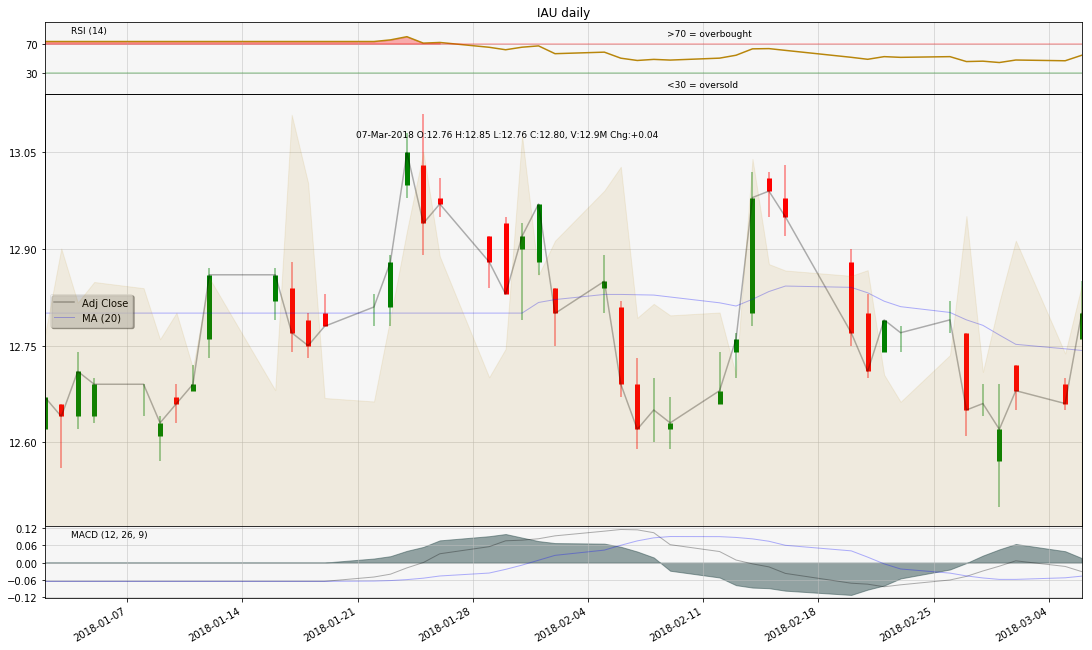

In [144]:
plt.rc('axes', grid=True)
plt.rc('grid', color='0.75', linestyle='-', linewidth=0.5)

textsize = 9
left, width = 0.1, 0.8
rect1 = [left, 0.7, width, 0.1]
rect2 = [left, 0.1, width, 0.6]
rect3 = [left, 0.0, width, 0.1]


fig = plt.figure(facecolor='white')
axescolor = '#f6f6f6'  # the axes background color

ax1 = fig.add_axes(rect1, facecolor=axescolor)  # left, bottom, width, height
ax2 = fig.add_axes(rect2, facecolor=axescolor, sharex=ax1)
ax2t = ax2.twinx()
ax3 = fig.add_axes(rect3, facecolor=axescolor, sharex=ax1)


# plot the relative strength indicator
#prices = r.adj_close
prices = r['Adj Close']
rsi = relative_strength(prices)
fillcolor = 'darkgoldenrod'
date = r.index

ax1.plot(date, rsi, color=fillcolor)
ax1.axhline(70, color='red', alpha=0.3)
ax1.axhline(30, color='green', alpha=0.3)
ax1.fill_between(date, rsi, 70, where=(rsi >= 70), facecolor='red', edgecolor='red', alpha=0.3)
ax1.fill_between(date, rsi, 30, where=(rsi <= 30), facecolor='green', edgecolor='green', alpha=0.3)
ax1.text(0.6, 0.9, '>70 = overbought', va='top', transform=ax1.transAxes, fontsize=textsize)
ax1.text(0.6, 0.1, '<30 = oversold', transform=ax1.transAxes, fontsize=textsize)
ax1.set_ylim(0, 100)
ax1.set_yticks([30, 70])
ax1.text(0.025, 0.95, 'RSI (14)', va='top', transform=ax1.transAxes, fontsize=textsize)
ax1.set_title('%s daily' % ticker)

ax1.set_xlim(date[0], date[-1])

# plot the price and volume data
#dx = r.adj_close - r.close
dx = r['Adj Close'] - r['Close']
#low = r.low + dx
low = r['Low'] + dx
#high = r.high + dx
high = r['High'] + dx
op = r['Open'] + dx
cl = r['Close'] + dx
adj = r['Adj Close']

#finance.candlestick_ohlc(ax2, r.values, width=5, colorup='g')

#deltas = np.zeros_like(prices)
#deltas[1:] = np.diff(prices)
#deltas = close 
up = cl >= op

# high and low
ax2.vlines(date[up], low[up], high[up], color='green', label='_nolegend_', alpha=0.5)
ax2.vlines(date[~up], low[~up], high[~up], color='red', label='_nolegend_', alpha=0.5)
# open and close
ax2.vlines(date[up], op[up], cl[up], color='green', label='_nolegend_', linewidths=5)
ax2.vlines(date[~up], op[~up], cl[~up], color='red', label='_nolegend_', linewidths=5)

ax2.plot(date, adj, color='black', label='Adj Close', alpha=0.3)


ma20 = moving_average(prices, 20, type='simple')
#ma200 = moving_average(prices, 200, type='simple')

linema20, = ax2.plot(date, ma20, color='blue', lw=1, label='MA (20)', alpha=0.3)
#linema200, = ax2.plot(date, ma200, color='red', lw=2, label='MA (200)')


last = r.iloc[-1]
s = '%s O:%1.2f H:%1.2f L:%1.2f C:%1.2f, V:%1.1fM Chg:%+1.2f' % (
    today.strftime('%d-%b-%Y'),
    last['Open'], last['High'],
    last['Low'], last['Close'],
    last['Volume']*1e-6,
    last['Close'] - last['Open'])
t4 = ax2.text(0.3, 0.9, s, transform=ax2.transAxes, fontsize=textsize)

props = font_manager.FontProperties(size=10)
leg = ax2.legend(loc='center left', shadow=True, fancybox=True, prop=props)
leg.get_frame().set_alpha(0.5)


volume = (r['Close']*r['Volume'])/1e6  # dollar volume in millions
vmax = volume.max()
poly = ax2t.fill_between(date, volume, 0, label='Volume', facecolor=fillcolor, edgecolor=fillcolor, alpha=0.1)
ax2t.set_ylim(0, 1.05*vmax)
ax2t.set_yticks([])


# compute the MACD indicator
fillcolor = 'darkslategrey'
nslow = 26
nfast = 12
nema = 9
emaslow, emafast, macd = moving_average_convergence(prices, nslow=nslow, nfast=nfast)
ema9 = moving_average(macd, nema, type='exponential')
ax3.plot(date, macd, color='black', lw=1, alpha=0.3)
ax3.plot(date, ema9, color='blue', lw=1, alpha=0.3)
ax3.fill_between(date, macd - ema9, 0, alpha=0.5, facecolor=fillcolor, edgecolor=fillcolor)


ax3.text(0.025, 0.95, 'MACD (%d, %d, %d)' % (nfast, nslow, nema), va='top',
         transform=ax3.transAxes, fontsize=textsize)

#ax3.set_yticks([])
# turn off upper axis tick labels, rotate the lower ones, etc
for ax in ax1, ax2, ax2t, ax3:
    if ax != ax3 :
        for label in ax.get_xticklabels():
            label.set_visible(False)
    else :
        for label in ax.get_xticklabels():
            label.set_rotation(30)
            label.set_horizontalalignment('right')

    ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')


class MyLocator(mticker.MaxNLocator):
    def __init__(self, *args, **kwargs):
        mticker.MaxNLocator.__init__(self, *args, **kwargs)

    def __call__(self, *args, **kwargs):
        return mticker.MaxNLocator.__call__(self, *args, **kwargs)

# at most 5 ticks, pruning the upper and lower so they don't overlap
# with other ticks
ax2.yaxis.set_major_locator(mticker.MaxNLocator(5, prune='both'))
ax3.yaxis.set_major_locator(mticker.MaxNLocator(5, prune='both'))

ax2.yaxis.set_major_locator(MyLocator(5, prune='both'))
ax3.yaxis.set_major_locator(MyLocator(5, prune='both'))

plt.show()